<h4>I used Claude, Anthropic's model to help with the code portion of this assignment.</h4>
<h4>I used Copilot for help understanding these concepts.</h4>

<p>(1) Find or come up with a model of simultaneous equations other than the supply and demand model that will result in endogeneity if one or more of the equations is estimated with OLS. Come up with one or more exogenous regressors that might be used to estimate the parameters of at least one of the equations in the system. Collect real data associated with your example, or simulated data associated with your example, and estimate it using OLS and IV or 2SLS.</p>

Chat GPT Assisted Answer
🏠 How Are House Equity and Purchasing Ability Interdependent?
House Equity → Purchasing Ability

If you already own a home and its value goes up, you gain equity.

That equity can be used as a down payment or collateral to buy another house.

So, more equity increases your ability to purchase.

Purchasing Ability → House Equity

If more people can afford homes (due to low interest rates or high income), demand rises.

That pushes up home prices, which increases equity for current homeowners.

So, greater purchasing ability boosts equity.

🔄 Why This Creates Endogeneity
Equity and purchasing power influence each other at the same time.

If you try to estimate the effect of equity on home buying without accounting for this feedback loop, your results will be biased.

That’s classic endogeneity — both variables are simultaneously determined.

Copilot assisted break down.
Purchasing Ability Equation: 
Purchase𝑖=𝛼+𝛽1⋅Equity𝑖+𝛽2⋅Income𝑖+𝜖𝑖

Equity Equation:
Equity𝑖=𝛾+𝛿1⋅Purchase𝑖+𝛿2⋅MarketPrice𝑖+𝜈𝑖

Each equation contains the other variable — that’s what makes it simultaneous.

<p>I like the idea of House Equity, and the ability to purchase a home</p>
<p>My initial thought is that while your home price increases, all the other surrounding homes will increase too. So after X amount of years you can afford a 1,000,000 home, but when you wanted it the value was 600,000.</p>
<p>After some initial research into this topic I found that while there may be some simultaneity in this situation, additional factors like inflation, income, and mortage rate will help me find out if variables are endogenous, meaning that there is some causation in the system.</p>

<a href="https://fred.stlouisfed.org/series/OEHRENWBSHNO">Households; Owners' Equity in Real Estate, Level </a>

<a href="https://fred.stlouisfed.org/series/CUUR0000SA0R">Consumer Price Index for All Urban Consumers: Purchasing Power of the Consumer Dollar in U.S. City Average</a>

<a href="https://fred.stlouisfed.org/series/FPCPITOTLZGUSA">Inflation, consumer prices for the United States</a>

<a href="https://fred.stlouisfed.org/series/MORTGAGE30US">30-Year Fixed Rate Mortgage Average in the United States</a>

<a href="https://fred.stlouisfed.org/series/MEHOINUSUTA672N">Real Median Household Income in Utah</a>

Equation 1: Home Equity (HE):

\begin{equation}
HE_t = \alpha_0 + \alpha_1 \cdot MORT_t + \alpha_2 \cdot INC_t + \alpha_3 \cdot INF_t + u_t
\end{equation}

$HE_t$: Owners' equity in real estate

$MORT_t$: Mortgage rate

$INC_t$: Real median household income

$INF_t$: Inflation

$u_t$: Error term


Equation 2: Purchasing Power (PP):

\begin{equation}
PP_t = \beta_0 + \beta_1 \cdot INF_t + \beta_2 \cdot INC_t + \beta_3 \cdot HE_t + v_t
\end{equation}

$PP_t$: Purchasing power index

$INF_t$: Inflation

$INC_t$: Income

$HE_t$: Home equity

$v_t$: Error term

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from linearmodels.iv import IV2SLS



In [185]:
def load_and_prepare(file, value_col_name):
    df = pd.read_csv(file, parse_dates=['observation_date'], index_col='observation_date')
    df.rename(columns={df.columns[0]: value_col_name}, inplace=True)
    return df

home_equity = load_and_prepare('../datasets/assignment6/home_equity.csv', 'home_equity')
purchasing_power = load_and_prepare('../datasets/assignment6/purchasing_power.csv', 'purchasing_power')
inflation = load_and_prepare('../datasets/assignment6/inflation.csv', 'inflation')
mortgage_rate = load_and_prepare('../datasets/assignment6/mortgage.csv', 'mortgage_rate')
income_utah = load_and_prepare('../datasets/assignment6/utah_median_household_income.csv', 'income_utah')

In [186]:
# Get min and max dates for each dataset
min_dates = [df.index.min() for df in [home_equity, purchasing_power, inflation, mortgage_rate, income_utah]]
max_dates = [df.index.max() for df in [home_equity, purchasing_power, inflation, mortgage_rate, income_utah]]

# Determine the shared date range
common_start = max(min_dates)
common_end = min(max_dates)

print("Common date range:", common_start, "to", common_end)

def restrict_dates(df, start, end):
    return df.loc[start:end]

home_equity = restrict_dates(home_equity, common_start, common_end)
purchasing_power = restrict_dates(purchasing_power, common_start, common_end)
inflation = restrict_dates(inflation, common_start, common_end)
mortgage_rate = restrict_dates(mortgage_rate, common_start, common_end)
income_utah = restrict_dates(income_utah, common_start, common_end)

# all not seasonally adjusted
home_equity = home_equity.reset_index() # Billions
purchasing_power = purchasing_power.reset_index() # index 1982-1984=100, not a dollar amount
inflation = inflation.reset_index() # percent
mortgage_rate = mortgage_rate.reset_index() # percent
income_utah = income_utah.reset_index() # 2024 C-CPI-U Dollars

# Rescale to common units

# Normalize all dates to the first day of the month
for df in [home_equity, purchasing_power, inflation, mortgage_rate, income_utah]:
    df['observation_date'] = df['observation_date'].dt.to_period('M').dt.to_timestamp()


Common date range: 1984-01-01 00:00:00 to 2024-01-01 00:00:00


In [187]:
# Merge datasets one by one on 'observation_date'
merged = pd.merge(home_equity, purchasing_power, on='observation_date', how='inner')
merged = pd.merge(merged, inflation, on='observation_date', how='inner')
merged = pd.merge(merged, mortgage_rate, on='observation_date', how='inner')
merged = pd.merge(merged, income_utah, on='observation_date', how='inner')

# Drop missing values
# merged.dropna(inplace=True)

# Scaling.
# numeric_cols = merged.select_dtypes(include=['float64', 'int64']).columns
# scaler = StandardScaler()
# scaled_data = pd.DataFrame(scaler.fit_transform(merged[numeric_cols]), columns=numeric_cols, index=merged.index)


# Optional: log-transform
merged['log_home_equity'] = np.log(merged['home_equity'])
merged['log_income_utah'] = np.log(merged['income_utah'])
# merged['log_purchasing_power'] = np.log(merged['purchasing_power'])
# merged['log_home_equity'] = np.log(merged['home_equity'])

merged.columns

Index(['observation_date', 'home_equity', 'purchasing_power', 'inflation',
       'mortgage_rate', 'income_utah', 'log_home_equity', 'log_income_utah'],
      dtype='object')

In [188]:
merged.count

<bound method DataFrame.count of     observation_date  home_equity  purchasing_power  inflation  mortgage_rate  \
0         1984-01-01     2671.738              98.2   4.300535          13.43   
1         1984-01-01     2671.738              98.2   4.300535          13.40   
2         1984-01-01     2671.738              98.2   4.300535          13.35   
3         1984-01-01     2671.738              98.2   4.300535          13.29   
4         1985-01-01     3040.155              94.6   3.545644          13.10   
..               ...          ...               ...        ...            ...   
166       2022-01-01    30498.347              35.6   8.002800           3.55   
167       2023-01-01    29830.846              33.4   4.116338           6.48   
168       2023-01-01    29830.846              33.4   4.116338           6.33   
169       2023-01-01    29830.846              33.4   4.116338           6.15   
170       2023-01-01    29830.846              33.4   4.116338           6.1

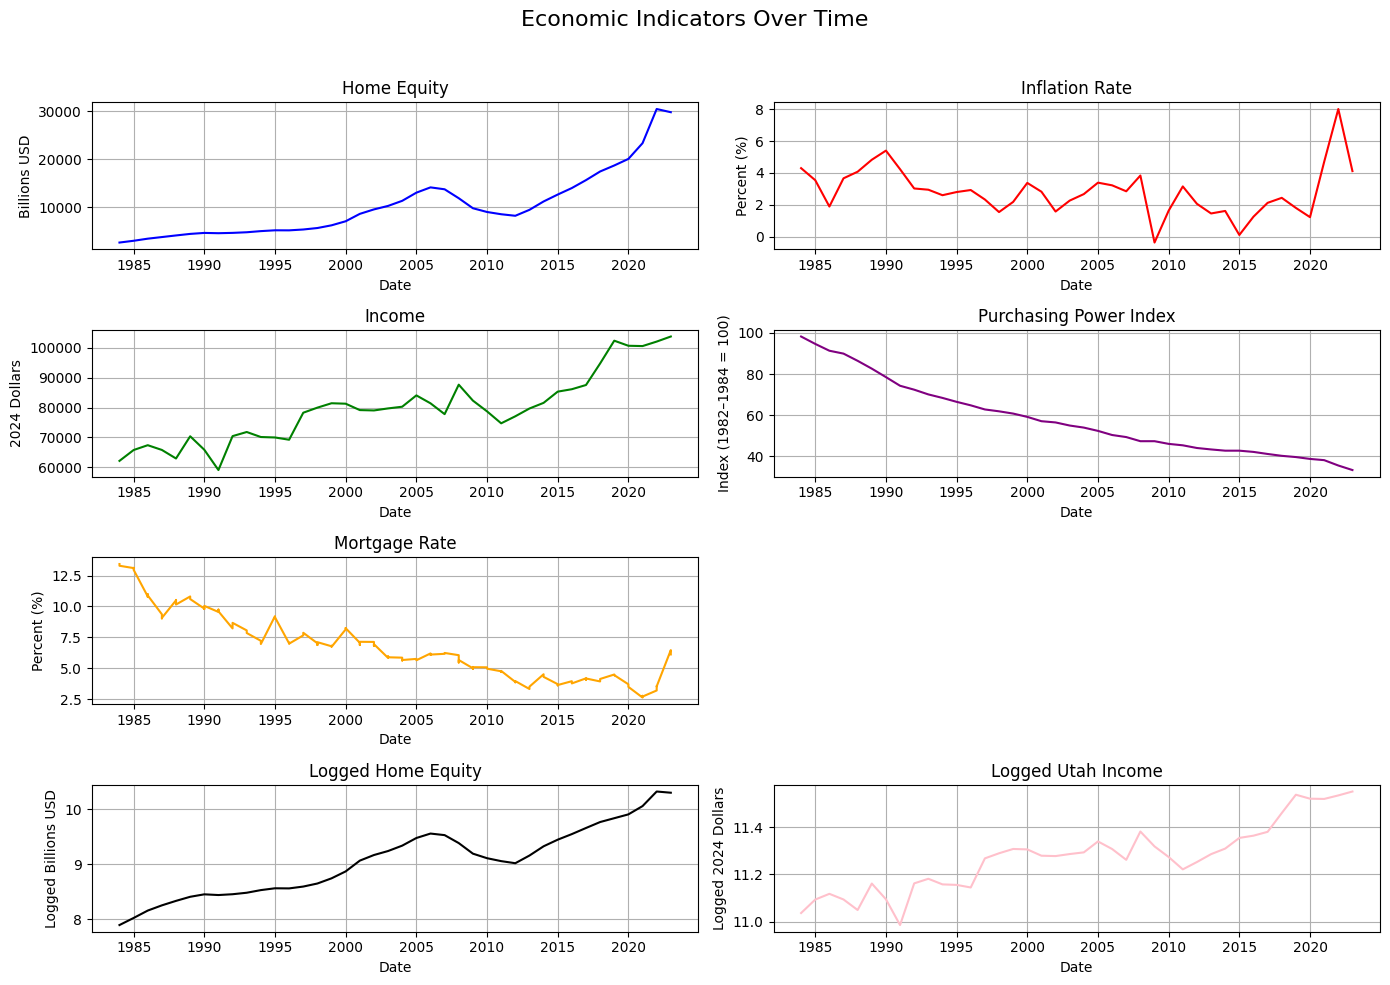

In [189]:
fig, axs = plt.subplots(4, 2, figsize=(14, 10))

# Home Equity
axs[0, 0].plot(merged['observation_date'], merged['home_equity'], color='blue')
axs[0, 0].set_title('Home Equity')
axs[0, 0].set_ylabel('Billions USD')
axs[0, 0].grid(True)

# Inflation
axs[0, 1].plot(merged['observation_date'], merged['inflation'], color='red')
axs[0, 1].set_title('Inflation Rate')
axs[0, 1].set_ylabel('Percent (%)')
axs[0, 1].grid(True)

# Income
axs[1, 0].plot(merged['observation_date'], merged['income_utah'], color='green')
axs[1, 0].set_title('Income')
axs[1, 0].set_ylabel('2024 Dollars')
axs[1, 0].grid(True)

# Purchasing Power
axs[1, 1].plot(merged['observation_date'], merged['purchasing_power'], color='purple')
axs[1, 1].set_title('Purchasing Power Index')
axs[1, 1].set_ylabel('Index (1982–1984 = 100)')
axs[1, 1].grid(True)

# Mortgage Rate
axs[2, 0].plot(merged['observation_date'], merged['mortgage_rate'], color='orange')
axs[2, 0].set_title('Mortgage Rate')
axs[2, 0].set_ylabel('Percent (%)')
axs[2, 0].grid(True)

# Logged Home Equity
axs[3, 0].plot(merged['observation_date'], merged['log_home_equity'], color='black')
axs[3, 0].set_title('Logged Home Equity')
axs[3, 0].set_ylabel('Logged Billions USD')
axs[3, 0].grid(True)

# Logged Utah Income
axs[3, 1].plot(merged['observation_date'], merged['log_income_utah'], color='pink')
axs[3, 1].set_title('Logged Utah Income')
axs[3, 1].set_ylabel('Logged 2024 Dollars')
axs[3, 1].grid(True)


# Hide empty subplot (bottom right)
fig.delaxes(axs[2, 1])

# Shared x-axis label
for ax in axs.flat:
    if ax:
        ax.set_xlabel('Date')

plt.suptitle('Economic Indicators Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [195]:
eq1 = IV2SLS.from_formula(
    'log_home_equity ~ 1 + mortgage_rate + log_income_utah + inflation',
    data=merged
).fit()


In [197]:
eq2 = IV2SLS.from_formula(
    'purchasing_power ~ 1 + inflation + log_income_utah + [log_home_equity ~ mortgage_rate]',
    data=merged
).fit()


In [196]:
print(eq1.summary)


                            OLS Estimation Summary                            
Dep. Variable:        log_home_equity   R-squared:                      0.9126
Estimator:                        OLS   Adj. R-squared:                 0.9111
No. Observations:                 171   F-statistic:                    3885.7
Date:                Thu, Oct 02 2025   P-value (F-stat)                0.0000
Time:                        13:58:26   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept          -21.472     2.3200    -9.2552     0.0000     -26.019     -16.925
mortgage_rate      -0.0935     0

In [198]:
print(eq2.summary)


                          IV-2SLS Estimation Summary                          
Dep. Variable:       purchasing_power   R-squared:                      0.8024
Estimator:                    IV-2SLS   Adj. R-squared:                 0.7989
No. Observations:                 171   F-statistic:                    1873.8
Date:                Thu, Oct 02 2025   P-value (F-stat)                0.0000
Time:                        13:58:29   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept          -618.16     152.44    -4.0550     0.0001     -916.94     -319.37
inflation           3.4742     0

<p>(2) Do some research on standard errors for IV and 2SLS estimators. Use this to decide the "best" standard error associated with your IV or 2SLS estimation above. This may be one of the standard errors I showed in the video or a different method. Creative/different approaches will be awarded, e.g., bootstrapping. </p>

In [ ]:
# todo